In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/Opti-ML') #to access other files
import os

In [ ]:
# Useful starting lines
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms, utils
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision.transforms import ToTensor

from optimizer import initialize_model

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


careful between similarity and distance => cka library gives similarity plot and
Linear CKA : (1 when A=B)
$$ 1-\frac{\|AB^T\|^2}{\|AA^T\|^2\|BB^T\|^2}$$
orthogonal procrustes (0 when A=B)
$$\|A\|^2+\|B\|^2-2\|AB^T\|$$

# Get models

In [ ]:

#Complete with the name
statedic_sgd=torch.load("/content/drive/MyDrive/Opti-ML/model_weights/model_test_sgd_0522.pt",map_location=torch.device('cpu'))
model_sgd,inputsize = initialize_model(use_pretrained=False)
model_sgd.load_state_dict(statedic_sgd)

statedic_ada=torch.load("/content/drive/MyDrive/Opti-ML/model_weights/model_test_adahessian_0522.pt",map_location=torch.device('cpu'))
model_ada,inputsize=initialize_model(use_pretrained=False)
model_ada.load_state_dict(statedic_ada)

#statedic_adasgd=torch.load()
#statedic_sgdada=torch.load()





<All keys matched successfully>

## Use example for CKA from https://github.com/AntixK/PyTorch-Model-Compare.git

In [ ]:
!pip install torch_cka

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torch_cka import CKA

In [ ]:
torch.manual_seed(20)
test_data=datasets.CIFAR10(root='data',train=False,download=True,transform=ToTensor()) #maybe need to be a bit careful with this between all our validation, test and train
testloader = DataLoader(test_data, batch_size=1000, shuffle=True)

Files already downloaded and verified


In [ ]:
cka = CKA(model_sgd, model_sgd,
          model1_name="model1",   # good idea to provide names to avoid confusion
          model2_name="model2",   
          device='cpu')

In [ ]:
cka.compare(testloader)

/usr/local/lib/python3.10/dist-packages/torch_cka/cka.py:145: UserWarning: Dataloader for Model 2 is not given. Using the same dataloader for both models.
  warn("Dataloader for Model 2 is not given. Using the same dataloader for both models.")
| Comparing features |: 100%|██████████| 10/10 [10:20<00:00, 62.07s/it]


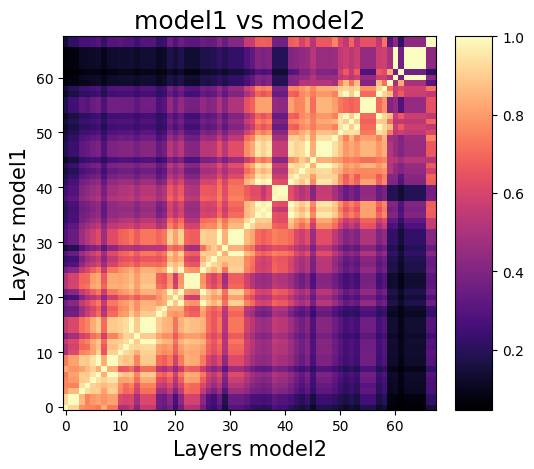

In [ ]:
cka.plot_results() 

## Use function from https://github.com/brando90/ultimate-anatome/tree/master

work less than more anien version anatome

In [ ]:
#with gpu : pip3 install torch==1.9.1+cu111 torchvision==0.10.1+cu111 torchaudio==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html
!pip install ultimate-anatome
!pip install ultimate-utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from anatome._distance import SimilarityHook,DistanceHook
from anatome.helper import remove_hook


In [ ]:
## tutorial
model=models.resnet18()
hook1 = DistanceHook(model, "layer3.0.conv1",'opd')
hook2 = DistanceHook(model, "layer3.0.conv1",'opd')
model.eval()
with torch.no_grad():
    model(torch.randn(128, 3, 224, 224))   #probleme ? need to evaluate after creating the hook, either hook matrix or each on a different datapoint
# downsampling to (size, size) may be helpful
print(hook1.distance(hook2, size=8))
hook1.clear()
hook2.clear()
remove_hook(model, hook1)
remove_hook(model, hook2)

x.size()=torch.Size([128, 120])


AssertionError: ignored

In [ ]:
torch.manual_seed(20)
test_data=datasets.CIFAR10(root='data',train=False,download=True,transform=ToTensor()) #maybe need to be a bit careful with this between all our validation, test and train
testloader = DataLoader(test_data, batch_size=128, shuffle=True)

100%|██████████| 170498071/170498071 [00:03<00:00, 51810112.94it/s]


Extracting data/cifar-10-python.tar.gz to data


In [ ]:
data=next(iter(testloader))[0]
data.shape

torch.Size([128, 3, 32, 32])

In [ ]:
hook1=DistanceHook(model_sgd,'','opd') #default pwcca
hook2=DistanceHook(model_sgd,'','opd')

model_sgd.eval()
model_ada.eval()
with torch.no_grad():
  data=next(iter(testloader))[0]
  model_sgd(data)
  model_ada(data)


hook2.distance(hook1) #pwcca don't work

0.0

In [ ]:
hook1.clear()
hook2.clear()
remove_hook(model_sgd, hook1)
remove_hook(model_sgd, hook2)

## use code from https://github.com/moskomule/anatome

In [ ]:
!pip install -U git+https://github.com/moskomule/anatome

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/moskomule/anatome to /tmp/pip-req-build-ac0_dacv
  Running command git clone --filter=blob:none --quiet https://github.com/moskomule/anatome /tmp/pip-req-build-ac0_dacv
  Resolved https://github.com/moskomule/anatome to commit 155ddb15e304b2285d315f4a50dbc23aeb2899cd
  Preparing metadata (setup.py) ... done


In [ ]:
torch.manual_seed(20)
test_data=datasets.CIFAR10(root='data',train=False,download=True,transform=ToTensor()) #maybe need to be a bit careful with this between all our validation, test and train
testloader = DataLoader(test_data, batch_size=20, shuffle=True)

Files already downloaded and verified


In [ ]:
from anatome import Distance

distance = Distance(model_sgd, model_sgd, method='lincka') #pwcca don't work , otherwise cvcaa and opdand linkcka (but also 0 for the same)
with torch.no_grad():
    data=next(iter(testloader))[0]
    distance.forward(data)

# resize if necessary by specifying `size`
distance.between("conv1", "conv1")

tensor(0.)

In [ ]:
notlayersname=['','layer1', 'layer1.0','layer1.1','layer2', 'layer2.0','layer2.1','layer3', 'layer3.0','layer3.1','layer4', 'layer4.0','layer4.1','layer2.0.downsample','layer3.0.downsample','layer3.0.downsample','layer4.0.downsample']
layersnames=[n for n, _ in model_sgd.named_modules() if n not in notlayersname]
print(layersnames)
#print(model_sgd.named_children)

['conv1', 'bn1', 'relu', 'maxpool', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.relu', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.relu', 'layer1.1.conv2', 'layer1.1.bn2', 'layer2.0.conv1', 'layer2.0.bn1', 'layer2.0.relu', 'layer2.0.conv2', 'layer2.0.bn2', 'layer2.0.downsample.0', 'layer2.0.downsample.1', 'layer2.1.conv1', 'layer2.1.bn1', 'layer2.1.relu', 'layer2.1.conv2', 'layer2.1.bn2', 'layer3.0.conv1', 'layer3.0.bn1', 'layer3.0.relu', 'layer3.0.conv2', 'layer3.0.bn2', 'layer3.0.downsample.0', 'layer3.0.downsample.1', 'layer3.1.conv1', 'layer3.1.bn1', 'layer3.1.relu', 'layer3.1.conv2', 'layer3.1.bn2', 'layer4.0.conv1', 'layer4.0.bn1', 'layer4.0.relu', 'layer4.0.conv2', 'layer4.0.bn2', 'layer4.0.downsample.0', 'layer4.0.downsample.1', 'layer4.1.conv1', 'layer4.1.bn1', 'layer4.1.relu', 'layer4.1.conv2', 'layer4.1.bn2', 'avgpool', 'fc']


In [ ]:
from anatome import Distance

distance = Distance(model_sgd, model_sgd, method='opd') #pwcca don't work , otherwise cvcaa and opdand linkcka (but also 0 for the same)
with torch.no_grad():
    data=next(iter(testloader))[0]
    distance.forward(data)

all_comparison=np.zeros([len(layersnames),len(layersnames)])
for i,layer1 in enumerate(layersnames):
  for j,layer2 in enumerate(layersnames):
    all_comparison[i,j]=distance.between(layer1,layer2)


In [ ]:
#from cka library 1
def add_colorbar(im, aspect=10, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

def plot_results(matrix,
                save_path: str = None,
                title: str = None):
    fig, ax = plt.subplots()
    im = ax.imshow(matrix, origin='lower', cmap='magma')
    ax.set_xlabel(f"Layers model 1", fontsize=15) #to modify
    ax.set_ylabel(f"Layers model 2", fontsize=15)

    if title is not None:
        ax.set_title(f"{title}", fontsize=18)
    else:
        ax.set_title(f" model1 vs model2", fontsize=18) # to modify

    add_colorbar(im)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=300)

    plt.show()

from mpl_toolkits import axes_grid1
import matplotlib.pyplot as plt


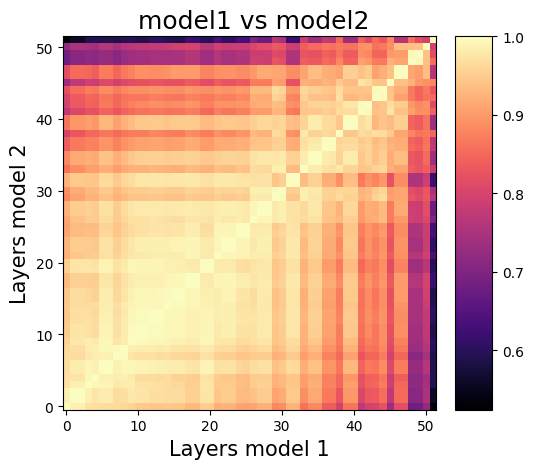

In [ ]:
plot_results(np.ones_like(all_comparison)-all_comparison)